# 1. Clustering the data

We talked today about how electricity markets work.

We will learn today how to simplify hourly data from electricity markets.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries.

Compared to day 1, we will be adding the the clustering library `Clustering`.


In [1]:
using Pkg
Pkg.add(["DataFrames", "CSV", "Clustering", "Plots", "StatsPlots", "Statistics", "StatsBase", "Printf", "Random", "FixedEffectModels"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed PDMats ──────────── v0.11.31
   Installed libdecor_jll ────── v0.2.2+0
   Installed IntelOpenMP_jll ─── v2024.2.0+0
   Installed Pango_jll ───────── v1.52.2+0
   Installed Ratios ──────────── v0.4.5
   Installed PtrArrays ───────── v1.2.0
   Installed FFTW ────────────── v1.8.0
   Installed OffsetArrays ────── v1.14.1
   Installed Dbus_jll ────────── v1.14.10+0
   Installed MKL_jll ─────────── v2024.2.0+0
   Installed oneTBB_jll ──────── v2021.12.0+0
   Installed KernelDensity ───── v0.6.9
   Installed AbstractFFTs ────── v1.5.0
   Installed ChainRulesCore ──── v1.24.0
   Installed Interpolations ──── v0.15.1
   Installed FFTW_jll ────────── v3.3.10+0
   Installed AliasTables ─────── v1.1.3
   Installed MultivariateStats ─ v0.10.3
   Installed Arpack_jll ──────── v3.5.1+1
   Installed Adapt ───────────── v4.0.4
   Installed StatsPlots ──────── v0.15.7
   Installed Arpack ──────────

In [3]:
using DataFrames
using CSV
using Clustering
using Plots
using StatsPlots
using Statistics, StatsBase
using Printf
using Random
using FixedEffectModels

In [4]:
dirpath = "/Users/marreguant/Documents/GitHub/DSE2024/13_Reguant/practicum/"

"/Users/marreguant/Documents/GitHub/DSE2024/13_Reguant/practicum/"

We load the data using the CSV syntax (`CSV.read`) into a data frame called `df`.  Here we need to do some cleaning of the variables, rescaling and dropping missing entries. Make sure the data is in the same directory as the notebook or specify the full path name.

In [5]:
# We read the data and clean it up a bit
df = CSV.read("data_jaere.csv", DataFrame)
df = sort(df,["year","month","day","hour"])
df = dropmissing(df)
df.nuclear = df.nuclear/1000.0
df.hydro = df.hydro/1000.0
df.imports = df.imports/1000.0
df.q_commercial = df.q_commercial/1000.0
df.q_industrial = df.q_industrial/1000.0
df.q_residential = df.q_residential/1000.0
df.hydronuc = df.nuclear + df.hydro 
df = select(df,Not(["nuclear","hydro"]))
first(df, 5)

Row,year,month,day,hour,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2011,1,2,1,29.5397,4.502,8.38001,2.05659,10.6404,0.019787,0.0,6.558
2,2011,1,2,2,27.9688,4.363,8.34789,2.06558,9.80354,0.0221706,0.0,6.455
3,2011,1,2,3,26.5258,4.089,8.54809,2.11851,9.5554,0.0269027,0.0,6.453
4,2011,1,2,4,25.5872,3.783,8.56002,2.13467,9.31031,0.0269792,0.0,6.407
5,2011,1,2,5,25.9229,3.969,8.61251,2.17499,9.4285,0.0310433,0.0,6.564


In [6]:
df

Row,year,month,day,hour,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2011,1,2,1,29.5397,4.502,8.38001,2.05659,10.6404,0.019787,0.0,6.558
2,2011,1,2,2,27.9688,4.363,8.34789,2.06558,9.80354,0.0221706,0.0,6.455
3,2011,1,2,3,26.5258,4.089,8.54809,2.11851,9.5554,0.0269027,0.0,6.453
4,2011,1,2,4,25.5872,3.783,8.56002,2.13467,9.31031,0.0269792,0.0,6.407
5,2011,1,2,5,25.9229,3.969,8.61251,2.17499,9.4285,0.0310433,0.0,6.564
6,2011,1,2,6,27.8414,4.141,8.81962,2.23299,9.73939,0.0369689,0.0,6.674
7,2011,1,2,7,27.8229,4.381,8.78951,2.29248,10.403,0.0340186,0.0611576,6.959
8,2011,1,2,8,28.093,4.74,8.24397,2.30747,11.6536,0.0323264,0.140097,6.788
9,2011,1,2,9,30.9623,5.298,8.09124,2.30744,13.0393,0.0330962,0.223541,7.034


In [7]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,year,2013.0,2011,2013.0,2015,0,Int64
2,month,6.5478,1,7.0,12,0,Int64
3,day,15.7486,1,16.0,31,0,Int64
4,hour,12.5064,1,13.0,24,0,Int64
5,price,35.5433,-13.9395,34.5713,172.352,0,Float64
6,imports,7.41422,1.571,7.446,11.674,0,Float64
7,q_commercial,12.1097,6.91611,11.458,26.0133,0,Float64
8,q_industrial,3.91344,1.95289,3.65441,8.53145,0,Float64
9,q_residential,10.5988,3.87066,9.8203,24.9831,0,Float64


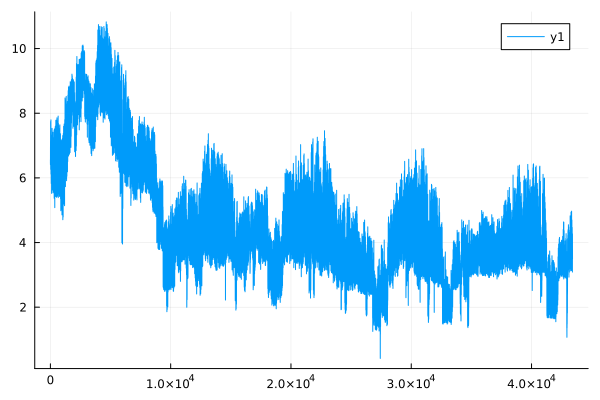

In [8]:
plot(rownumber.(eachrow(df)),df.hydronuc)

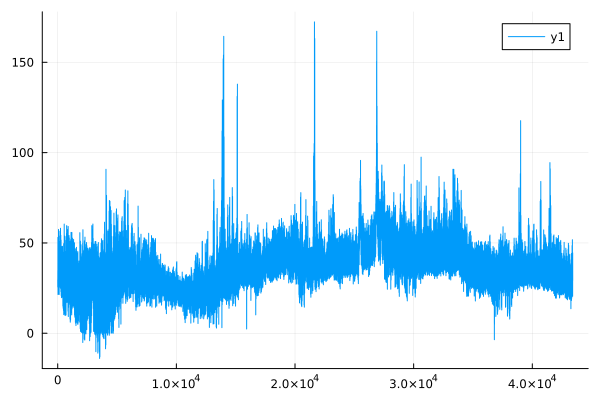

In [9]:
plot(rownumber.(eachrow(df)),df.price)

## Clustering our data

When modeling electricity markets, oftentimes the size of the problem can make the solver slow.

Here we will be using a clustering algorithm to come up with a (much) smaller synthetic dataset that we will use for the purposes of our main analysis.

**Note:** We ignore the time variables when we cluster.

In [10]:
n = 100
X = transpose(Array(select(df,Between(:price,:hydronuc))));

# We scale variables to improve kmeans performance. For that, we take the mean and std of each row (dim=2) and you repeat it by the number of columns (rows in df)
Xs = (X.- repeat(mean(X,dims=2),1,nrow(df)))./repeat(std(X,dims=2),1,nrow(df)); 

#we set seed because kmeans picks random samples to generate clusters
Random.seed!(2020)
R = kmeans(Xs, n);

# Get the cluster centers rescaling again
M = R.centers .* repeat(std(X,dims=2),1,n) .+ repeat(mean(X,dims=2),1,n);  

# R = kmeans(X, n);
# M = R.centers; 


8×100 Matrix{Float64}:
 44.8507    40.2834      70.1554    …  50.291       62.2489    17.7275
  7.25688    8.47216      8.07499       8.63424      4.91079    8.4835
 15.6342    11.5798      15.0325       12.366       13.394     11.2062
  6.24111    4.06036      6.11547       4.03427      4.72638    3.31419
 11.3666    14.155       20.0267       12.7299       8.48676    8.80595
  0.481806   0.411881     0.398612  …   0.170711     0.209196   0.59856
  0.785586   0.00733263   0.505725      0.00888704   0.266805   0.00479378
  4.61597    3.95377      5.78134       4.15224      2.53903    3.43986

In [11]:
dfclust = DataFrame(transpose(M),
["price", "imports", "q_commercial", "q_industrial", "q_residential", 
        "wind_cap", "solar_cap", "hydronuc"]);
dfclust.weights = counts(R);
first(dfclust, 5)

Row,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,44.8507,7.25688,15.6342,6.24111,11.3666,0.481806,0.785586,4.61597,287
2,40.2834,8.47216,11.5798,4.06036,14.155,0.411881,0.00733263,3.95377,628
3,70.1554,8.07499,15.0325,6.11547,20.0267,0.398612,0.505725,5.78134,180
4,26.5618,7.02309,10.0495,3.91292,8.15435,0.662615,0.0102827,3.43998,760
5,37.0007,5.6396,10.0141,3.54231,10.0543,0.208139,0.450361,2.79729,427


In [12]:
dfclust

Row,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,44.8507,7.25688,15.6342,6.24111,11.3666,0.481806,0.785586,4.61597,287
2,40.2834,8.47216,11.5798,4.06036,14.155,0.411881,0.00733263,3.95377,628
3,70.1554,8.07499,15.0325,6.11547,20.0267,0.398612,0.505725,5.78134,180
4,26.5618,7.02309,10.0495,3.91292,8.15435,0.662615,0.0102827,3.43998,760
5,37.0007,5.6396,10.0141,3.54231,10.0543,0.208139,0.450361,2.79729,427
6,37.998,6.61716,9.33798,3.20469,8.74743,0.141276,0.0105646,2.32021,699
7,43.3107,9.1167,19.8993,7.09356,5.91624,0.232668,0.577826,4.80506,145
8,32.181,8.7686,14.153,3.59615,9.66465,0.192524,0.112814,7.10583,415
9,44.9164,6.89629,15.5495,5.22585,6.4413,0.209247,0.0267234,4.0169,228


We can compare the distribution of outcomes between the original dataset and the new dataset.

Here is an example with prices. The two distributions are very similar.

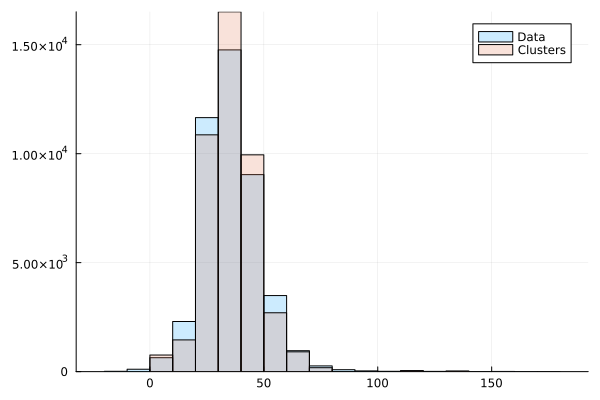

In [13]:
histogram(df.price, fillalpha=.2, nbins=20, label="Data")
histogram!(dfclust.price, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

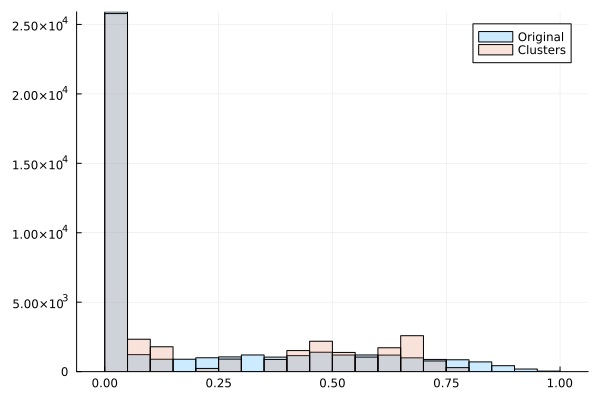

In [14]:
histogram(df.solar_cap, fillalpha=.2, nbins=20, label="Original")
histogram!(dfclust.solar_cap, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

We can also check that the correlation between the main variables of interest remains similar.


We can visualize the correlations directly, allowing for a correction for weights. 

We can see that the overall correlation patterns are quite good, capturing mot of the relationships in the data accurately.

In [17]:
MatOriginal = cor(Array(select(df,[:price,:imports,:wind_cap,:solar_cap])))

4×4 Matrix{Float64}:
  1.0        0.141085  -0.0628841   0.183123
  0.141085   1.0        0.221393    0.172096
 -0.0628841  0.221393   1.0        -0.0647719
  0.183123   0.172096  -0.0647719   1.0

In [18]:
MatClust = cor(Array(select(dfclust,[:price, :imports,:wind_cap,:solar_cap])), Weights(dfclust.weights))

4×4 Matrix{Float64}:
  1.0        0.182049  -0.0709533   0.220261
  0.182049   1.0        0.292251    0.208546
 -0.0709533  0.292251   1.0        -0.0785681
  0.220261   0.208546  -0.0785681   1.0

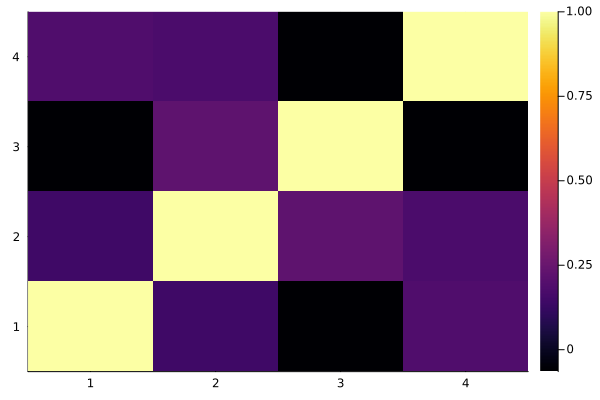

In [19]:
heatmap(MatOriginal)

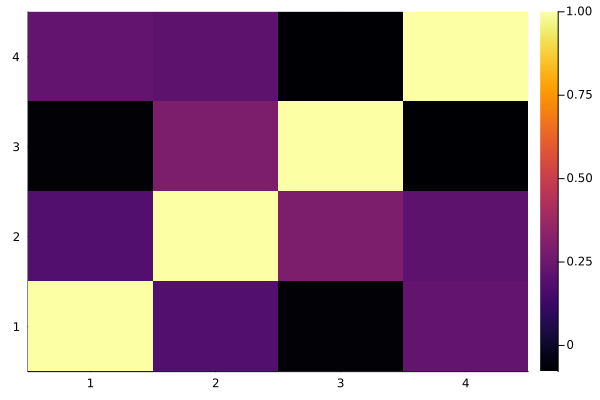

In [20]:
heatmap(MatClust)

We can check how the correlation of solar and price depend on controls.

In [21]:
reg_nocontrols = reg(df, @formula(price ~ solar_cap))

                             FixedEffectModel                             
Number of obs:                 43408   Converged:                      true
dof (model):                       1   dof (residuals):               43405
R²:                            0.034   R² adjusted:                   0.034
F-statistic:                 1506.09   P-value:                       0.000
             Estimate  Std. Error    t-stat  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
solar_cap     8.70683   0.224355    38.8083    <1e-99    8.26709    9.14657
(Intercept)  33.932     0.0728545  465.751     <1e-99   33.7893    34.0748


In [22]:
reg_controls = reg(df, @formula(price ~ solar_cap + q_commercial + q_residential + q_industrial))

                               FixedEffectModel                               
Number of obs:                   43408  Converged:                        true
dof (model):                         4  dof (residuals):                 43402
R²:                              0.361  R² adjusted:                     0.361
F-statistic:                   6122.57  P-value:                         0.000
                Estimate  Std. Error    t-stat  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
solar_cap      -3.25132    0.231945   -14.0177    <1e-43   -3.70594  -2.79671
q_commercial    0.511169   0.0260911   19.5917    <1e-84    0.46003   0.562308
q_residential   1.83079    0.0163532  111.953     <1e-99    1.79874   1.86284
q_industrial    4.20145    0.0555422   75.6442    <1e-99    4.09259   4.31031
(Intercept)    -5.89129    0.309115   -19.0586    <1e-79   -6.49716  -5.28542


We save the clustered data.

In [23]:
CSV.write(string(dirpath,"data_jaere_clustered_",n,".csv"), dfclust)

"/Users/marreguant/Documents/GitHub/DSE2024/13_Reguant/practicum/data_jaere_clustered_100.csv"